In [ ]:
import pandas as pd

# Lade die CSV-Datei
data = pd.read_csv('../raw_data/WELFake_Dataset.csv')

In [140]:
data = df.copy()

In [141]:
data.drop('Unnamed: 0',axis=1,inplace=True)

In [142]:
print(f"data.shape: {data.shape}")

data.shape: (72134, 3)


In [143]:
data = data.head(45000)

In [144]:
data.shape

(45000, 3)

## combine title and text, and delete title

In [ ]:
## Cleaning 2: combine the text and the title
## Cleaning 1: filling the missing data with spaces
data = data.fillna(' ') ## aplying to na via fillna

## Cleaning 2: combine the text and the title
data['text'] = data['title'] + data['text']

## delete title column
data.drop('title',axis=1,inplace=True)

In [146]:
print(f"data.shape: {data.shape}")

data.shape: (45000, 2)


## check balance

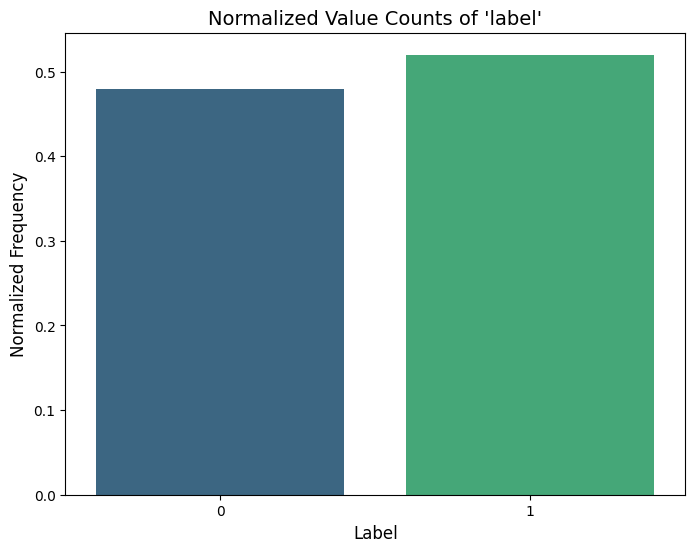

In [147]:
# wieviel ist von labe 1 und 0
import matplotlib.pyplot as plt
import seaborn as sns

# Berechne die normalisierten Werte
label_counts = round(data["label"].value_counts(normalize=True), 2)

# Erstelle den Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")

# Füge Titel und Achsenbezeichner hinzu
plt.title("Normalized Value Counts of 'label'", fontsize=14)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Normalized Frequency", fontsize=12)

# Zeige den Plot
plt.show()

## check nulls

In [148]:
# nun werte zählen
nan_in_df = data.isna().sum()
print(nan_in_df)
# Berechne den Prozentsatz der NaN-Werte in jeder Spalte
nan_percentage = (data.isna().sum() / len(data)) * 100
print(nan_percentage)

text     0
label    0
dtype: int64
text     0.0
label    0.0
dtype: float64


## delete duplicated raws

In [149]:
data.drop_duplicates(inplace=True)

## Data Basic Cleaning: strip, lower, digit, punctuation

In [ ]:
import re
import string

def basic_cleaning(texte):
    # stripping:
    data['text'] = data['text'].str.strip()

    # lower:
    data['text'] = data['text'].str.lower()

    # digit: Entferne Ziffern aus jeder Zeile der Spalte 'text'
    data['text'] = data['text'].apply(lambda x: ''.join(char for char in x if not char.isdigit()))

    # punctuation: Entferne alle Satzzeichen aus der 'text'-Spalte
    data['text'] = data['text'].str.replace(r'[{}]'.format(re.escape(string.punctuation)), '', regex=True)

    # delete html-tags
    data['text'] = data['text'].apply(lambda x: re.sub('<[^<]+?>', '', x))

    return data['text']

In [151]:
import time
s = time.time()
data['text'] = basic_cleaning(data['text'])
time_to_clean = time.time() - s
print('Time to basic clean {:.2f} s'.format(time_to_clean))

Time to basic clean 20323.86 s


In [152]:
data.head()

,text,label
0,law enforcement on high alert following threat...,1
1,did they post their votes for hillary already,1
2,unbelievable obama’s attorney general says mos...,1
3,bobby jindal raised hindu uses story of christ...,0
4,satan russia unvelis an image of its terrifyi...,1


## nlp cleaning: tokenizing, stopwords, lemmatize

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))

# Tokenisieren und Stopwörter entfernen
def delete_stop_words(text):
    # Entferne Stopwörter und Satzzeichen
    text = [word for word in text if word.lower() not in stop_words and word not in string.punctuation]
    return text

# Lemmatization-Funktion anwenden
def lemmatize_text(text):

    # Lemmatize Verben
    verb_lemmatized = [
        WordNetLemmatizer().lemmatize(word, pos="v")  # v --> Verben
        for word in text
    ]

    # Lemmatize Nomen
    noun_lemmatized = [
        WordNetLemmatizer().lemmatize(word, pos="n")  # n --> Nomen
        for word in verb_lemmatized
    ]

    return noun_lemmatized

def nlp_cleaning(texte):

    # Tokenisierung auf jede Zeile der Spalte 'text' anwenden
    texte = texte.apply(word_tokenize)

    # delete stopwars
    texte = texte.apply(delete_stop_words)

    # lemmatize text
    texte = texte.apply(lemmatize_text)

    # Füge die Wörter wieder zu einem String zusammen
    texte = texte.apply(lambda x: ' '.join(x))

    return texte

In [ ]:
s = time.time()
data['text'] = nlp_cleaning(data['text'])
time_to_clean = time.time() - s
print('Time to nlp clean {:.2f} s'.format(time_to_clean))

In [ ]:
data.head(10)

In [ ]:
# Shuffle the dataframe
data = data.sample(frac=1,random_state=42)

In [ ]:
X = data['text']
y = data['label']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Create tokenization and modelling pipeline
model_NB = Pipeline([
                    ("tfidf",TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf",MultinomialNB())]) # model the text

# Fit the pipeline to the training data
model_NB.fit(X_train, y_train)
test_score = model_NB.score(X_test,y_test)
test_score